In [3]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob

os.environ['BEEP_ENV'] = 'dev'

In [4]:
from beep import validate, structure, featurize

In [5]:
from matplotlib import pyplot as plt
from monty.serialization import loadfn

In [12]:
data_dir = 'OldData' # Directory for old data
data_dir2 = 'TrajectoryFastCharge' # Directory for TrajectoryFastCharge

In [13]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if ".json" in fullPath:
            allFiles.append(fullPath)
    return allFiles

In [14]:
def convert_to_float(lst):
    if type(lst) != int:
        return lst[0]
    else:
        return lst

Getting Features

In [15]:
file_list = getListOfFiles(data_dir)
print(len(file_list))
file_list

93


['OldData/b1_CH25_features_DeltaQFastCharge.json',
 'OldData/b1_CH36_features_DeltaQFastCharge.json',
 'OldData/b3_CH09_features_DeltaQFastCharge.json',
 'OldData/b2_CH14_features_DeltaQFastCharge.json',
 'OldData/b3_CH40_features_DeltaQFastCharge.json',
 'OldData/b3_CH05_features_DeltaQFastCharge.json',
 'OldData/b2_CH42_features_DeltaQFastCharge.json',
 'OldData/b3_CH03_features_DeltaQFastCharge.json',
 'OldData/b2_CH18_features_DeltaQFastCharge.json',
 'OldData/b2_CH44_features_DeltaQFastCharge.json',
 'OldData/b2_CH36_features_DeltaQFastCharge.json',
 'OldData/b1_CH01_features_DeltaQFastCharge.json',
 'OldData/b2_CH25_features_DeltaQFastCharge.json',
 'OldData/b2_CH23_features_DeltaQFastCharge.json',
 'OldData/b1_CH14_features_DeltaQFastCharge.json',
 'OldData/b1_CH07_features_DeltaQFastCharge.json',
 'OldData/b2_CH30_features_DeltaQFastCharge.json',
 'OldData/b3_CH21_features_DeltaQFastCharge.json',
 'OldData/b2_CH29_features_DeltaQFastCharge.json',
 'OldData/b3_CH27_features_Delt

In [16]:
df = pd.DataFrame()
for file in file_list:
    with open(file) as data_file:    
        data = json.load(data_file)
        data_df = pd.json_normalize(data)
        df = pd.concat([df,data_df])
df.reset_index(drop=True,inplace=True)
df['name'] = df['name'].apply(lambda x: x[177:184])
df.head()

,@module,@class,name,@version,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,...,X.internal_resistance_cycle_2,X.internal_resistance_difference_cycles_2:100,X.nominal_capacity_by_median,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.init_pred_cycle,metadata.parameters.mid_pred_cycle,metadata.parameters.final_pred_cycle,metadata.parameters.n_nominal_cycles
0,beep.featurize,DeltaQFastCharge,b1_CH25,2021.1.11.15,[1.0763277],[0.003585400000000183],[1.0779946000000002],[2975.0627476810896],[12.010000228881836],[-0.052046771407138336],...,[0.016699276864528656],[-1.1263415217399597e-05],[1.0792274499999999],None,None,None,10,91,100,40
1,beep.featurize,DeltaQFastCharge,b1_CH36,2021.1.11.15,[1.0791167],[0.0032426000000000954],[1.0801983],[2794.8609377964985],[11.4399995803833],[-0.258932723171391],...,[0.016480684280395508],[8.785165846347809e-05],[1.08183155],None,None,None,10,91,100,40
2,beep.featurize,DeltaQFastCharge,b3_CH09,2021.1.11.15,[1.0703383999999998],[0.003032300000000321],[1.0724221],[2625.932595220391],[10.010000228881836],[-0.017954987815446428],...,[0.015903223305940628],[-2.9396265745162964e-05],[1.0732100999999998],None,None,None,10,91,100,40
3,beep.featurize,DeltaQFastCharge,2_CH14_,2021.1.11.15,[1.0795292],[0.0033539000000000208],[1.0808307],[3284.2708926935547],[10.010000228881836],[-0.027128299287228062],...,[0.017164165154099464],[-0.00013306736946105957],[1.082511],None,None,None,10,91,100,40
4,beep.featurize,DeltaQFastCharge,b3_CH40,2021.1.11.15,[1.0598956],[0.003937899999999939],[1.0617945],[2661.5345749262233],[10.010000228881836],[-0.03156294153624195],...,[0.01556191872805357],[-0.00023430492728948593],[1.0636619],None,None,None,10,91,100,40


Response variable data

In [17]:
file_list2 = getListOfFiles(data_dir2)
file_list2 = file_list2[:len(file_list2)-2]

In [18]:
print(len(file_list2))
file_list2

91


['TrajectoryFastCharge/b3_CH31_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b1_CH25_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH23_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH42_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH31_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b1_CH01_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b3_CH01_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b1_CH07_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH37_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b3_CH18_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH44_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b3_CH13_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b1_CH15_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH25_features_TrajectoryFastCharge.json',
 'TrajectoryFastCharge/b2_CH13_features_Trajecto

In [19]:
df2 = pd.DataFrame()
for file in file_list2:
    with open(file) as data_file:    
        data = json.load(data_file)
        data_df = pd.json_normalize(data)
        df2 = pd.concat([df2,data_df])
df2.reset_index(drop=True,inplace=True)
df2['name'] = df2['name'].apply(lambda x: x[181:188])
df2.head()

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,b3_CH31,2021.1.11.15,[436],[596],[649],[678],[702],[723],[730],None,None,None,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,b1_CH25,2021.1.11.15,[457],[632],[698],[751],[799],[837],[853],None,None,None,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,2_CH23_,2021.1.11.15,[222],[374],[433],[466],[492],[515],[526],None,None,None,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,2_CH42_,2021.1.11.15,[245],[245],[245],[416],[435],[453],[465],None,None,None,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,2_CH31_,2021.1.11.15,[289],[378],[417],[443],[464],[482],[491],None,None,None,0.98,0.78,0.03


In [20]:
# df_full = df.merge(df2,'inner',left_index=True,right_index=True)
df_full = df.merge(df2,'inner',on = 'name')


# Making values not stored as lists
for column in df_full.columns:
    if "X." in column:
        df_full[column] = df_full[column].apply(lambda x: x[0])

df_full

,@module_x,@class_x,name,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,X.abs_min_discharge_capacity_difference_cycles_2:100,...,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,DeltaQFastCharge,b1_CH25,2021.1.11.15,1.076328,0.003585,1.077995,2975.062748,12.010000,-0.052047,...,751,799,837,853,None,None,None,0.98,0.78,0.03
1,beep.featurize,DeltaQFastCharge,b1_CH36,2021.1.11.15,1.079117,0.003243,1.080198,2794.860938,11.440000,-0.258933,...,624,656,687,703,None,None,None,0.98,0.78,0.03
2,beep.featurize,DeltaQFastCharge,b3_CH09,2021.1.11.15,1.070338,0.003032,1.072422,2625.932595,10.010000,-0.017955,...,963,996,1026,1038,None,None,None,0.98,0.78,0.03
3,beep.featurize,DeltaQFastCharge,2_CH14_,2021.1.11.15,1.079529,0.003354,1.080831,3284.270893,10.010000,-0.027128,...,437,457,474,484,None,None,None,0.98,0.78,0.03
4,beep.featurize,DeltaQFastCharge,b3_CH40,2021.1.11.15,1.059896,0.003938,1.061794,2661.534575,10.010000,-0.031563,...,733,765,792,795,None,None,None,0.98,0.78,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,beep.featurize,DeltaQFastCharge,b1_CH04,2021.1.11.15,1.079012,0.005304,1.082596,2977.746621,12.010000,-0.032234,...,1489,1578,1663,1708,None,None,None,0.98,0.78,0.03
87,beep.featurize,DeltaQFastCharge,b1_CH02,2021.1.11.15,1.081315,0.006738,1.084945,3044.688062,13.339999,-0.037030,...,1485,1485,2192,2236,None,None,None,0.98,0.78,0.03
88,beep.featurize,DeltaQFastCharge,2_CH35_,2021.1.11.15,1.069063,0.005425,1.071662,3358.231993,10.010000,-0.057712,...,423,440,456,462,None,None,None,0.98,0.78,0.03
89,beep.featurize,DeltaQFastCharge,2_CH26_,2021.1.11.15,1.078936,0.003590,1.077315,3160.050112,10.010000,-0.035069,...,416,440,459,470,None,None,None,0.98,0.78,0.03


In [21]:
df_full.keys()

Index(['@module_x', '@class_x', 'name', '@version_x',
       'X.discharge_capacity_cycle_2', 'X.max_discharge_capacity_difference',
       'X.discharge_capacity_cycle_100',
       'X.integrated_time_temperature_cycles_1:100',
       'X.charge_time_cycles_1:5',
       'X.abs_min_discharge_capacity_difference_cycles_2:100',
       'X.abs_mean_discharge_capacity_difference_cycles_2:100',
       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
       'X.abs_skew_discharge_capacity_difference_cycles_2:100',
       'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
       'X.abs_first_discharge_capacity_difference_cycles_2:100',
       'X.max_temperature_cycles_1:100', 'X.min_temperature_cycles_1:100',
       'X.slope_discharge_capacity_cycle_number_2:100',
       'X.intercept_discharge_capacity_cycle_number_2:100',
       'X.slope_discharge_capacity_cycle_number_91:100',
       'X.intercept_discharge_capacity_cycle_number_91:100',
       'X.min_internal_resistance_cycl

In [41]:
df['X.abs_min_discharge_capacity_difference_cycles_2:100'] = (df['X.abs_min_discharge_capacity_difference_cycles_2:100'].
                                                             apply(lambda x : x[0]))

In [45]:
df['X.abs_kurtosis_discharge_capacity_difference_cycles_2:100'] = (df['X.abs_kurtosis_discharge_capacity_difference_cycles_2:100'].
                                                             apply(lambda x : x[0]))

In [47]:
df['X.slope_discharge_capacity_cycle_number_2:100'] = (df['X.slope_discharge_capacity_cycle_number_2:100'].
                                                             apply(lambda x : x[0]))

In [50]:
df['X.intercept_discharge_capacity_cycle_number_91:100'] = (df['X.intercept_discharge_capacity_cycle_number_91:100'].
                                                           apply(lambda x: x[0]))

In [55]:
df['X.discharge_capacity_cycle_2'] = (df['X.discharge_capacity_cycle_2'].
                                     apply(lambda x : x[0]))

In [57]:
df['X.charge_time_cycles_1:5'] = (df['X.charge_time_cycles_1:5'].
                                 apply(lambda x : x[0]))

In [58]:
df['X.integrated_time_temperature_cycles_1:100'] = (df['X.integrated_time_temperature_cycles_1:100'].
                                                   apply(lambda x : x[0]))

In [60]:
df['X.min_internal_resistance_cycles_2:100'] = (df['X.min_internal_resistance_cycles_2:100'].
                                               apply(lambda x : x[0]))

In [62]:
df['X.internal_resistance_difference_cycles_2:100'] = (df['X.internal_resistance_difference_cycles_2:100'].
                                                      apply(lambda x : x[0]))

Model Recreation

In [63]:
"""
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
"""                        
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5',
                       'X.integrated_time_temperature_cycles_1:100',
                       'X.min_internal_resistance_cycles_2:100',
                       'X.internal_resistance_difference_cycles_2:100']
y = df_full['X.capacity_0.8']

Variance Model

In [64]:
from sklearn.linear_model import LinearRegression

<AxesSubplot:xlabel='X.abs_variance_discharge_capacity_difference_cycles_2:100', ylabel='X.capacity_0.8'>

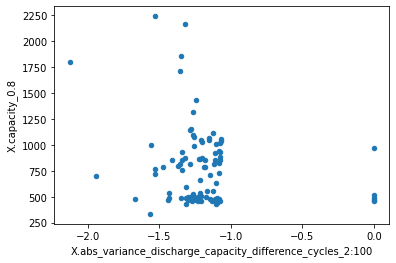

In [65]:
df_full.plot.scatter(x='X.abs_variance_discharge_capacity_difference_cycles_2:100', y = 'X.capacity_0.8')

In [73]:
X = df_full[full_model_features].values

In [75]:
reg = LinearRegression().fit(X,y)

In [78]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = reg.predict(X)
print("Training MSE: ", mean_squared_error(y, y_pred))
print("R2 :", r2_score(y, y_pred))


Training MSE:  33542.908457990714
R2 : 0.7575772430746192
